In [38]:
import autograd.numpy as np
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH

In [2]:
# Toggle VI solver debug prints (per-iteration rho/error). Set to False to silence.
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
DEBUG_VI = False  # change to False to disable verbose VI logging
ImplicitEquationSolver.debug_vi = DEBUG_VI
print(f"VI debug logging enabled: {DEBUG_VI}")

VI debug logging enabled: False


In [3]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from collections import deque
import math

C1 = 1/9
C2 = 1
R = 1/0.7
m = 0.8
L = 1/7
eps_sign = 1e-6


# alpha = 9.
# beta = 15.
# b = -5/7
# k=1.5

Y0 = np.array([0.15264,-0.02281,0.38127])
# Y0 = np.array([9.998048,1.980972,-10.908448])

t_span = (0.0, 10.0)

# Constraint force function: returns friction only for the velocity DOF.
def con_force(Y):
    con_forces = np.zeros_like(Y)
    con_forces[0] = m
    con_forces[1] = 0.0
    con_forces[2] = 0.0
    return con_forces

# ODE system: [velocity, position]
def CHUA_rhs(t, Y):
    x, y, z = Y
    dxdt = (y-x)/(R) 
    dydt = (x-y)/(R) + z
    dzdt = -y
    return np.array([dxdt,dydt,dzdt])

# Block matrix A: first block for velocities (with mass M), second for displacements (I)
A = np.array([[C1, 0.0, 0.0],
                [0.0, C2, 0.0],
                [0, 0, L]])    # effectively zero

# ----------------------------------------------------------------
# (3) Set up the custom solver using the projection.
# ----------------------------------------------------------------
def run_CHUA_custom():
    # Initial conditions (currents and capacitor voltage)
    h_initial = 1e-3

    # Define the state partition:
    # For a 3D state, we define:
    #   component_slices = [slice(0,1), slice(1,2), slice(2,3)]
    # The user is free to assign friction to any DOF.
    component_slices = [slice(0,1), slice(1,2), slice(2,3)]

    # For this circuit, we want constraints on the two inductor currents (DOFs 0 and 1) and none on z.
    # Therefore, set rhok as a vector of length 3:
    rhok = np.array([1.0,1.0,1.0])
    # And explicitly supply constraint_indices:
    constraint_indices = [0]

    # Create the projection with the user-supplied constraint indices.
    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices
    )

    # Configure the implicit equation solver.
    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7
    )
    method_mp = CompositeMethod(solver=solver_mp, A=A)
    system = ODESystem(
        fun=CHUA_rhs,  # smooth RHS; constraint handled by projection
        y0=Y0,
        method=method_mp,
        adaptive=True,
        component_slices=component_slices,
        atol=1e-8,
        rtol=1e-6,
        verbose = True,
    )
    solver_instance = ODESolver(system, t_span, h_initial)
    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()
    return t_vals, y_vals, fk_vals

# ----------------------------------------------------------------
# (4) Alternate ODE for solve_ivp (with explicit sign terms)
# ----------------------------------------------------------------
def sign_reg(x, eps):
    # return np.tanh(x/eps)
    # return np.sign(x)
    return x/(np.abs(x)+eps)

def CHUA_rhs_with_reg(t, Y, eps):
    x, y, z = Y
    dxdt = (y-x)/(R*C1) - m*sign_reg(x, eps_sign)/C1
    dydt = (x-y)/(R*C2) + z/C2
    dzdt = -y/L
    return np.array([dxdt,dydt,dzdt])

# ----------------------------------------------------------------
# (5) Full Example: Compare custom solver vs. solve_ivp for CHUA.
# ----------------------------------------------------------------
def example_CHUA():
    # 1) Run custom solver (smooth RHS + projection)
    start_time = time.time()
    t_custom, y_custom, fk_custom = run_CHUA_custom()
    print('Custom time: {:.2f} seconds'.format(time.time() - start_time))

    # Using the regularized sign function defined above:
    start_time = time.time()
    sol_ivp = solve_ivp(
        fun=lambda t, Y: CHUA_rhs_with_reg(t, Y, eps_sign),
        t_span=t_span,
        y0=Y0,
        method='BDF',
        # rtol=1e-8,
        # atol=1e-6,
        # max_step=1e-3
    )
    if sol_ivp.success==False: print("Success:",sol_ivp.success)
    print('IVP time: {:.2f} seconds'.format(time.time() - start_time))
    return t_custom, y_custom, fk_custom, sol_ivp.t, sol_ivp.y

t_custom, y_custom, fk_custom, sol_ivp_t, sol_ivp_y = example_CHUA()

 convergent reject @ t=0,h -> 6.000e-04
[adaptive] reject @ t=0.0042, E=2.061e+00 ⇒ h -> 4.426e-03
[adaptive] reject @ t=0.0042, E=1.620e+00 ⇒ h -> 3.232e-03
[adaptive] reject @ t=0.0136942, E=1.210e+00 ⇒ h -> 2.715e-03
[adaptive] reject @ t=0.018926, E=9.279e+00 ⇒ h -> 1.408e-03
[adaptive] reject @ t=0.018926, E=3.345e+00 ⇒ h -> 8.448e-04
[adaptive] reject @ t=0.0401259, E=2.171e+00 ⇒ h -> 1.006e-02
[adaptive] reject @ t=0.691224, E=1.005e+00 ⇒ h -> 7.919e-03
[adaptive] reject @ t=1.89693, E=1.018e+00 ⇒ h -> 7.808e-03
Custom time: 7.85 seconds
IVP time: 0.01 seconds


/tmp/ipykernel_39755/3405363706.py:31: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


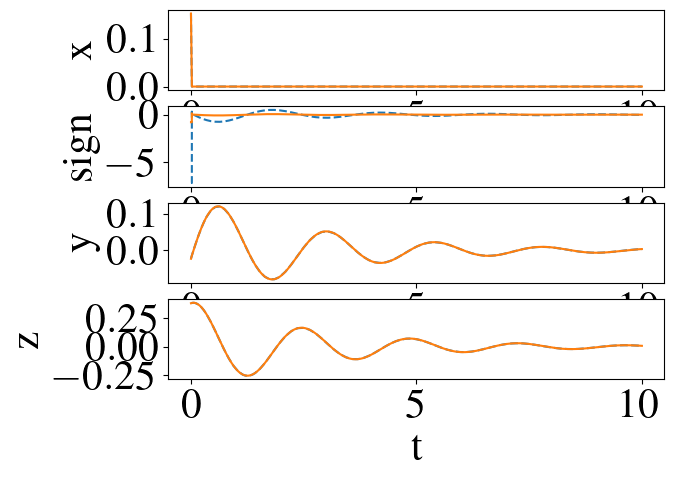

In [4]:
# 3) Plot and compare.
# plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(sol_ivp_t, sol_ivp_y[0, :], '--', label='solve_ivp')
plt.plot(t_custom, y_custom[:, 0], label='custom')
plt.ylabel('x')
plt.xlabel('t')
# plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sol_ivp_t, -m/C1*sign_reg(sol_ivp_y[0, :],eps_sign), '--', label='solve_ivp')
plt.plot(t_custom[1:], fk_custom[:, 0], label='custom')
plt.ylabel('sign')
plt.xlabel('t')
# plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sol_ivp_t, sol_ivp_y[1, :], '--', label='solve_ivp')
plt.plot(t_custom, y_custom[:, 1], label='custom')
plt.ylabel('y')
plt.xlabel('t')
# plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sol_ivp_t, sol_ivp_y[2, :], '--', label='solve_ivp')
plt.plot(t_custom, y_custom[:, 2], label='custom')
plt.ylabel('z')
plt.xlabel('t')
# plt.legend()

plt.tight_layout()
plt.show()   

In [5]:
import numpy as np
alpha = 2
def my_reward_fn(solver_perf, dt_attempt, xk, env):
    """
    User‐provided reward function.
    Receives:
      - solver_perf: a list containing [runtime, dt, error_LO, error_lil1, error_HI, error,
                          success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI]
      - dt_attempt: the time‐step attempted
      - xk: the current state
      - env: the environment instance (for accessing dt_min, dt_max, etc.)
    """
    runtime_inc, dt, error_LO, error_lil1, error_HI, error, \
        success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI = solver_perf
    if dt == 0:
        reward = - (dt_attempt - env.dt_min) / (env.dt_max - env.dt_min)
    else:
        S1 = (dt - env.dt_min) / (env.dt_max - env.dt_min)
        # Track per-step runtime and update the running maximum to normalize S2 dynamically
        # Initialize runtime history and max on the env if missing
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))
        # Maintain a running max runtime seen so far
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
        rt_min = 0.0001
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom
        if S2 < 0:
          print(f'runtime is: {runtime_inc}')
        A = np.exp(-alpha * error)
        reward = S1 * S2 * A
        # print(f'error: {error}, error_term:{A}, runtime:{runtime_inc}, runtime_term:{S2}')

    return reward

def my_obs_fn(dt_attempt, converged, xk, solver_perf,fk,env):
    """
    User‐provided observation function.
    Receives:
      - dt_attempt: the attempted dt (or None on reset)
      - converged: a flag (e.g. 1 if the solver step succeeded, else 0)
      - error: the computed error (E) from the solver step
      - xk: the current state (as passed in by the environment)
      - solver_perf: the full solver performance vector
      - env: the environment instance (for additional parameters)
    Here we return an observation vector that, for example, includes:
      - The friction average (env.fricavg)
      - The average velocity (computed from xk)
      - The normalized iteration error (env.iter_error/4)
      - The convergence flag
      - The normalized error (error/2)
      - The normalized dt_attempt
    (Users can modify this as needed.)
    """

    if dt_attempt is None:
        # For reset, return a default observation.
        x, y, z = xk
        x0, y0, z0 = Y0
        ie = 1/2* C1 * x**2 + 1/2* C2 * y**2 + 1/2* L * z**2 
        ie0 = 1/2* C1 * x0**2 + 1/2* C2 * y0**2 + 1/2* L * z0**2 
        ie_norm = ie/ie0
        z_norm = z/z0
        x_norm = x/x0
        y_norm = y/y0
        return np.array([ie_norm, z_norm,x_norm,y_norm, 1.005, 1., 1., 1.], dtype=np.float64)
    else:
        runtime_inc, dt, error_LO, error_lil1, error_HI, error, \
        success_LO, success_lil1, success_HI, kiter_LO, iter_lil1, kiter_HI = solver_perf
        x, y, z = xk
        x0, y0, z0 = Y0

        ie = 1/2* C1 * x**2 + 1/2* C2 * y**2 + 1/2* L * z**2 
        ie0 = 1/2* C1 * x0**2 + 1/2* C2 * y0**2 + 1/2* L * z0**2 
        ie_norm = ie/ie0
        z_norm = z/z0
        x_norm = x/x0
        y_norm = y/y0

        # avg_v = np.mean(xk[0]) / .1 #extract out the velocity of the state; velocity/initial velocity
        return np.array([ie_norm, z_norm,x_norm,y_norm, env.iter_error / 4, converged,
                        np.exp(-alpha * error),
                         (dt_attempt - env.dt_min) / (env.dt_max - env.dt_min)],
                        dtype=np.float64)





In [8]:
# --- Example: FOSM Projection ---

def example_chua_and_RL():
    # Constraint force function: returns friction only for the velocity DOF.
    C1 = 1/9
    C2 = 1
    R = 1/0.7
    m = 0.8
    L = 1/7
    eps_sign = 1e-6


    # alpha = 9.
    # beta = 15.
    # b = -5/7
    # k=1.5

    Y0 = np.array([0.15264,-0.02281,0.38127])
# Y0 = np.array([9.998048,1.980972,-10.908448])

    t_span = (0.0, 10.0)
    def con_force(Y):
        con_forces = np.zeros_like(Y)
        con_forces[0] = m
        con_forces[1] = 0.0
        con_forces[2] = 0.0
        return con_forces

    # ODE system: [velocity, position]
    def CHUA_rhs(t, Y):
        x, y, z = Y
        dxdt = (y-x)/(R) 
        dydt = (x-y)/(R) + z
        dzdt = -y
        return np.array([dxdt,dydt,dzdt])

    # Block matrix A: first block for velocities (with mass M), second for displacements (I)
    A = np.array([[C1, 0.0, 0.0],
                  [0.0, C2, 0.0],
                  [0, 0, L]])    # effectively zero
    h_initial = 0.001

    # Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
    component_slices = [slice(0,1), slice(1,2), slice(2,3)]
    constraint_indices = [0]
    # For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
    rhok = np.array([1.0,1.0,1.0])

    # Create the projection operator
    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices
    )

    # Configure the implicit solver (using the VI method here)
    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7
    )

    # Use the composite method (which calls the solver internally)
    method_mp = CompositeMethod(solver=solver_mp, A=A)

    # --- Now set up the RL training for adaptive time stepping ---
    #
    # Here we build a custom Gym environment where the agent’s action (a number in [0,1])
    # is mapped to a time step in [dt_min, dt_max]. The environment performs one integration step
    # using our composite method and returns an observation (state, dt, error, etc.) and a reward.
    #
    dt0 = 0.01
    t0 = t_span[0]
    tnmax = t_span[1]
    dt_min = 1e-5
    dt_max = 1.0
    nparams = (1e-6, 500)

    # Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
    obs_dim = 8
    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

    # Create the custom environment
    env = AdaptiveStepperEnv(
        system=CHUA_rhs,
        dt0=dt0,
        t0=t0,
        x0=Y0,
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False,
        atol = 1e-8,
        rtol = 1e-6,
    )

    # Wrap the environment in a vectorized wrapper and normalization (from stable-baselines3)
    vec_env = DummyVecEnv([lambda: env])
    vec_env = VecNormalize(vec_env, norm_obs=False, norm_reward=False)

    # Set up the RL algorithm (here we use TQC)
    policy_kwargs = dict(
        activation_fn=th.nn.ReLU,
        net_arch=dict(pi=[64, 64], qf=[64, 64, 64])
    )
    callback = CustomMetricsCallback()

    model = TQC("MlpPolicy", vec_env, batch_size=256, use_sde=True, verbose=0, policy_kwargs=policy_kwargs)

    print("Starting RL training for adaptive time stepping...")
    start_time = time.time()
    # model.learn(total_timesteps=20000, callback=[callback])
    model.learn(total_timesteps=20000)

    print('Training time: {:.2f} seconds'.format(time.time() - start_time))

    # Save the trained model and environment normalization stats
    model.save("Chua_TQC_adaptive_timestepping_model")
    vec_env.save("Chua_vec_normalize_adaptive_timestepping.pkl")

if __name__ == "__main__":
    example_chua_and_RL()

Starting RL training for adaptive time stepping...
Training time: 411.98 seconds


Using cuda device
Starting TD3 training for adaptive time stepping...
---------------------------
| time/              |    |
|    episodes        | 4  |
|    fps             | 69 |
|    time_elapsed    | 1  |
|    total_timesteps | 83 |
---------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 63       |
|    time_elapsed    | 2        |
|    total_timesteps | 167      |
| train/             |          |
|    actor_loss      | 0.136    |
|    critic_loss     | 0.00163  |
|    ent_coef        | 0        |
|    learning_rate   | 0.001    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 12       |
|    fps             | 58       |
|    time_elapsed    | 3        |
|    total_timesteps | 215      |
| train/             |          |
|    actor_loss      | 0.126    |
|    critic_loss     | 0.0018   |
|    ent_coef       

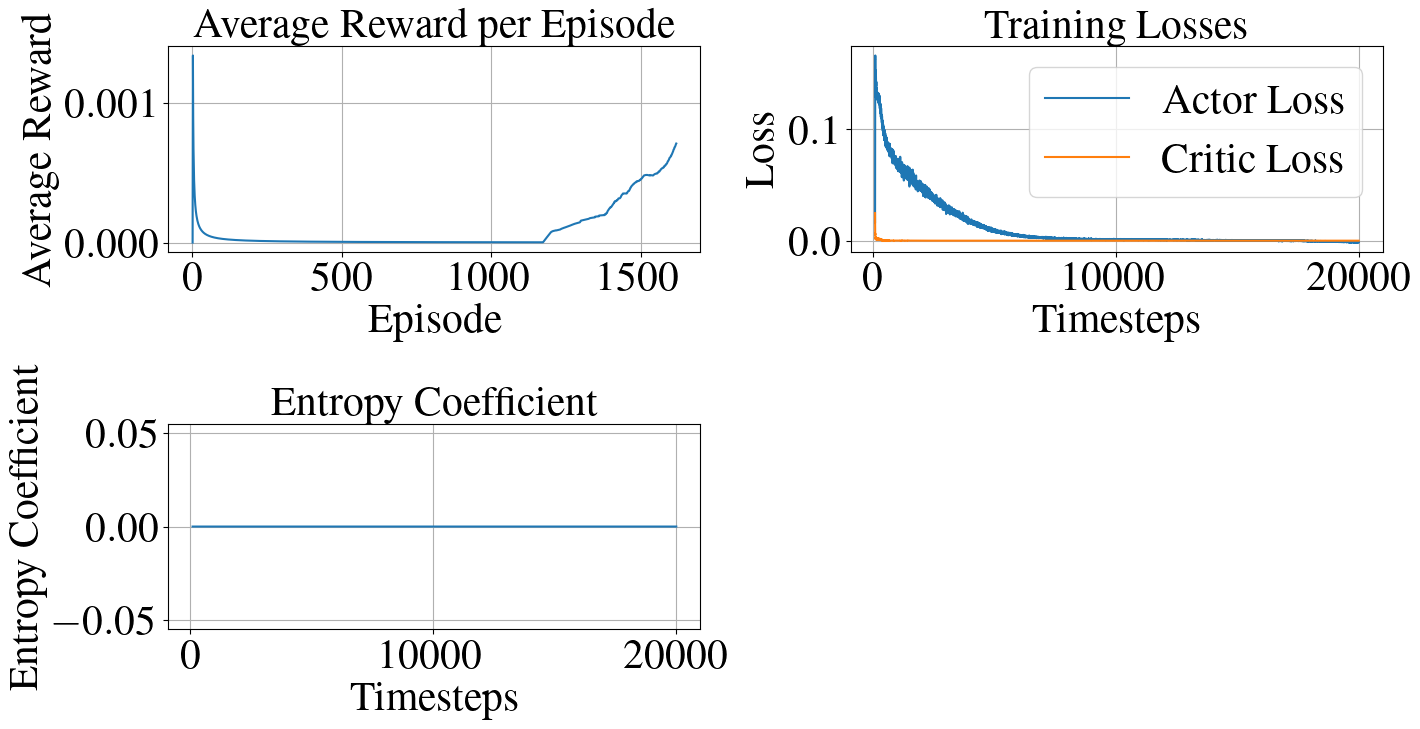

TD3 training time: 433.17 seconds
Saved TD3 model and VecNormalize stats.


In [9]:
# --- TD3 training with the same env/time-step settings as the TQC cell ---
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import DummyVecEnv
from gymnasium import spaces

# Build the exact same environment as in the TQC training cell
def _build_env_for_td3():
    # Constraint force function
    def con_force(Y):
        con_forces = np.zeros_like(Y)
        con_forces[0] = m
        con_forces[1] = 0.0
        con_forces[2] = 0.0
        return con_forces

    # ODE system: [velocity, position]
    def CHUA_rhs(t, Y):
        x, y, z = Y
        dxdt = (y-x)/(R) 
        dydt = (x-y)/(R) + z
        dzdt = -y
        return np.array([dxdt,dydt,dzdt])

    # Block matrix A: first block for velocities (with mass M), second for displacements (I)
    A = np.array([[C1, 0.0, 0.0],
                  [0.0, C2, 0.0],
                  [0, 0, L]])    # effectively zero
    h_initial = 0.001

    # Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
    component_slices = [slice(0,1), slice(1,2), slice(2,3)]
    constraint_indices = [0]
    # For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
    rhok = np.array([1.0,1.0,1.0])

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method='VI',
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )

    method_mp = CompositeMethod(solver=solver_mp, A=A)

    dt0 = 0.01
    t0 = t_span[0]
    tnmax = t_span[1]
    dt_min = 1e-5
    dt_max = 1.0
    nparams = (1e-6, 500)

    # Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
    obs_dim = 8
    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

    # Create the custom environment
    env = AdaptiveStepperEnv(
        system=CHUA_rhs,
        dt0=dt0,
        t0=t0,
        x0=Y0,
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False,
        atol=1e-8,
        rtol=1e-6,
    )
    return env

# Vectorize and normalize, same as TQC
vec_env_td3 = DummyVecEnv([_build_env_for_td3])
vec_env_td3 = VecNormalize(vec_env_td3, norm_obs=False, norm_reward=False)

# TD3 with same network size as TQC
policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64])
)
model_td3 = TD3("MlpPolicy", vec_env_td3, verbose=1, policy_kwargs=policy_kwargs)

print("Starting TD3 training for adaptive time stepping...")
start_time = time.time()
callback_td3 = CustomMetricsCallback()
model_td3.learn(total_timesteps=20000, callback=[callback_td3])
print('TD3 training time: {:.2f} seconds'.format(time.time() - start_time))

# Save TD3 model and corresponding VecNormalize stats
model_td3.save("Chua_TD3_adaptive_timestepping_model")
vec_env_td3.save("Chua_vec_normalize_adaptive_timestepping.pkl")
print("Saved TD3 model and VecNormalize stats.")

In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3 import TD3
from sb3_contrib import TQC


C1 = 1/9
C2 = 1
R = 1/0.7
m = 0.8
L = 1/7
eps_sign = 1e-6


# alpha = 9.
# beta = 15.
# b = -5/7
# k=1.5

Y0 = np.array([0.15264,-0.02281,0.38127])
# Y0 = np.array([9.998048,1.980972,-10.908448])

t_span = (0.0, 10.0)
dt_max = 0.1
# -----------------------------------------------------------------------------
# Helper functions (CHUA dynamics and projection)
# -----------------------------------------------------------------------------
# Constraint force function: returns friction only for the velocity DOF.
def con_force(Y):
    con_forces = np.zeros_like(Y)
    con_forces[0] = m
    con_forces[1] = 0.0
    con_forces[2] = 0.0
    return con_forces

# ODE system: [velocity, position]
def CHUA_rhs(t, Y):
    x, y, z = Y
    dxdt = (y-x)/(R) 
    dydt = (x-y)/(R) + z
    dzdt = -y
    return np.array([dxdt,dydt,dzdt])

# Block matrix A: first block for velocities (with mass M), second for displacements (I)
A = np.array([[C1, 0.0, 0.0],
                [0.0, C2, 0.0],
                [0, 0, L]])    # effectively zero


def _align_time_with_step_series(t_array, step_series):
    """
    Align a time array that contains states at grid points with a per-step series (e.g., residual/force).
    The per-step series usually has length len(t_array)-1 (or similar).
    We robustly map to the last len(step_series) time stamps.
    """
    n = len(step_series)
    return np.asarray(t_array, dtype=float)[-n:]

def _only_x_component(vec_like):
    """
    Return the x-component (index 0) from a residual/force array that may be:
      - 1D already (assumed x), or
      - 2D with shape (T, nstate), or
      - any shape that can be flattened per-sample (take [0]).
    """
    arr = np.asarray(vec_like, dtype=float)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        # assume columns correspond to state components, take column 0
        return arr[:, 0]
    # fallback: last dimension is components
    return np.reshape(arr, (arr.shape[0], -1))[:, 0]

# -----------------------------------------------------------------------------
# Heuristic runners (return FULL state histories and x-only fk)
# -----------------------------------------------------------------------------
def run_CHUA_custom(use_PI: bool = True):
    """
    Run adaptive solver with PI controller (default) or P-only when use_PI=False.
    Returns:
      t_vals: (N,) times
      Y_vals: (N,3) full state history
      fkx_vals: (N-1,) x-component of step force series (solver-dependent length)
    """
    h_initial = 1e-3
    component_slices = [slice(0,1), slice(1,2), slice(2,3)]

    # For this circuit, we want constraints on the two inductor currents (DOFs 0 and 1) and none on z.
    # Therefore, set rhok as a vector of length 3:
    rhok = np.array([1.0,1.0,1.0])
    # And explicitly supply constraint_indices:
    constraint_indices = [0]

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method="VI",
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp, A=A)
    system = ODESystem(
        fun=CHUA_rhs,
        y0=Y0,
        method=method_mp,
        adaptive=True,
        component_slices=component_slices,
        atol=1e-8,
        rtol=1e-6,
    )
    if hasattr(system, "adaptive_stepper"):
        system.adaptive_stepper.h_min = 1e-5
        system.adaptive_stepper.h_max = dt_max
        system.adaptive_stepper.use_PI = bool(use_PI)
    else:
        raise AttributeError("Adaptive stepper not found on system. Check your ODESystem implementation.")

    solver_instance = ODESolver(system, t_span, h_initial)
    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()

    t_vals = np.asarray(t_vals, dtype=float)
    y_vals = np.asarray(y_vals, dtype=float)  # (N,3)
    fk_vals = np.asarray(fk_vals, dtype=float)
    fkx_vals = _only_x_component(fk_vals)

    return t_vals, y_vals, fkx_vals

def run_CHUA_constant(dt_ref: float = 1e-2):
    """
    Run a constant time-step simulation as a reference.
    Returns:
      t_vals: (N,)
      Y_vals: (N,3)
      fkx_vals: x-component of per-step force series
    """
    component_slices = [slice(0, 1)]
    constraint_indices = [0]
    rhok = np.array([1.0])

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method="VI",
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp, A=A)
    system = ODESystem(
        fun=CHUA_rhs,
        y0=Y0,
        method=method_mp,
        adaptive=False,
        component_slices=component_slices,
    )
    solver_instance = ODESolver(system, t_span, dt_ref)
    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()

    t_vals = np.asarray(t_vals, dtype=float)
    y_vals = np.asarray(y_vals, dtype=float)
    fk_vals = np.asarray(fk_vals, dtype=float)
    fkx_vals = _only_x_component(fk_vals)

    return t_vals, y_vals, fkx_vals



Running adaptive CHUA with P-only controller...


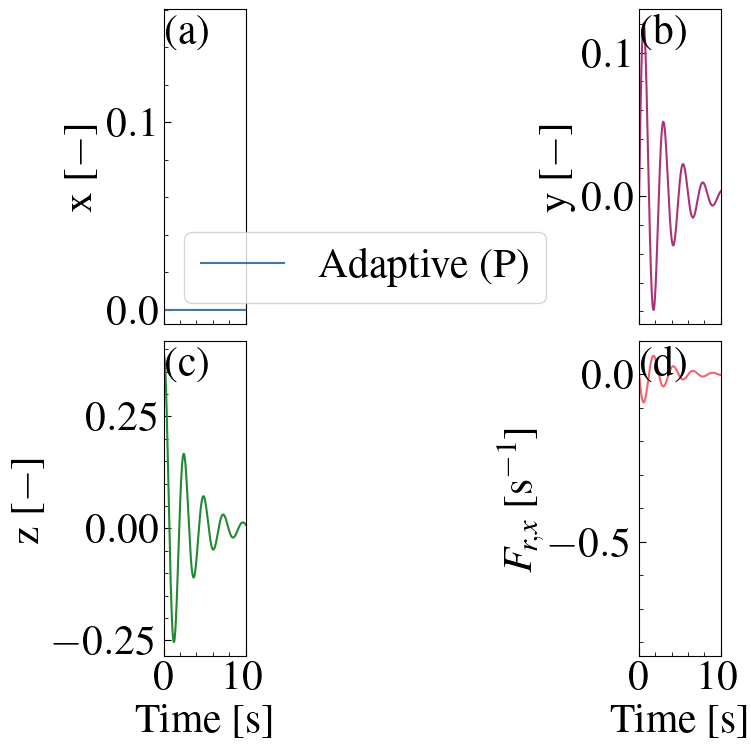

Adaptive run complete and plotted.


In [11]:
# Run adaptive solver (PI or P-only) and plot results directly
use_PI = False  # set False for P-only control in the adaptive stepper


# Execute adaptive run
print(f"Running adaptive CHUA with {'PI' if use_PI else 'P-only'} controller...")
t_adapt, Y_adapt, fkx_adapt = run_CHUA_custom(use_PI=use_PI)

# Align per-step force time series (usually length N-1) to the last timestamps
n_force = len(fkx_adapt)
t_force = np.asarray(t_adapt, dtype=float)[-n_force:] if n_force > 0 else np.asarray([])

# Plot: x(t), y(t), z(t), and F_{r,x}(t)
fig, axes = plt.subplots(2, 2, figsize=(7.4, 7.4), constrained_layout=True, sharex=True)
(ax_x, ax_y), (ax_z, ax_f) = axes

# Optional styling
for _ax in (ax_x, ax_y, ax_z, ax_f):
    _ax.minorticks_on()
    _ax.tick_params(axis="both", which="both", direction="in")
    _ax.tick_params(axis="both", which="major", length=5)
    _ax.tick_params(axis="both", which="minor", length=3)
    _ax.grid(False)

ax_x.plot(t_adapt, Y_adapt[:, 0], label=f"Adaptive ({'PI' if use_PI else 'P'})", color="#4477AA")
ax_x.set_ylabel("x [−]")
ax_x.text(0.02, 0.98, "(a)", transform=ax_x.transAxes, va="top", ha="left")
ax_x.legend(loc="best", frameon=True)

ax_y.plot(t_adapt, Y_adapt[:, 1], color="#AA3377")
ax_y.set_ylabel("y [−]")
ax_y.text(0.02, 0.98, "(b)", transform=ax_y.transAxes, va="top", ha="left")

ax_z.plot(t_adapt, Y_adapt[:, 2], color="#228833")
ax_z.set_xlabel("Time [s]")
ax_z.set_ylabel("z [−]")
ax_z.text(0.02, 0.98, "(c)", transform=ax_z.transAxes, va="top", ha="left")

if n_force > 0:
    ax_f.plot(t_force, fkx_adapt, color="#EE666F")
ax_f.set_xlabel("Time [s]")
ax_f.set_ylabel(r"$F_{r,x}$ [s$^{-1}$]")
ax_f.text(0.02, 0.98, "(d)", transform=ax_f.transAxes, va="top", ha="left")

# Consistent x-limits
ax_x.set_xlim(t_span[0], t_span[1])

plt.show()
print("Adaptive run complete and plotted.")

In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3 import TD3
from sb3_contrib import TQC


C1 = 1/9
C2 = 1
R = 1/0.7
m = 0.8
L = 1/7
eps_sign = 1e-6


# alpha = 9.
# beta = 15.
# b = -5/7
# k=1.5

# Y0 = np.array([0.15264,-0.02281,0.38127])
Y0 = np.array([9.998048,1.980972,-10.908448])

t_span = (0.0, 20.0)
# # -----------------------------------------------------------------------------
# # Preconditions (defined in earlier cells in your notebook)
# # -----------------------------------------------------------------------------
# _needed = ["C1", "C2", "R", "L", "Y0", "t_span"]
# for _k in _needed:
#     if _k not in globals():
#         raise NameError(
#             f"Missing required variable `{_k}`. "
#             "Define your CHUA parameters and initial state earlier in the notebook, e.g., "
#             "`C1, C2, R, L, Y0, t_span`."
#         )

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
tmax = t_span[1]
dt_max = 2.0
# Y0 = np.array([9.998048,1.980972,-10.908448])

BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR
PLOTS_DIR = BASE_DIR / "Images"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Save paths for heuristic (PI) and P-only variants
CUSTOM_RESULTS_PATH = RESULTS_DIR / "custom_results.npz"       # PI
CUSTOM_RESULTS_P_PATH = RESULTS_DIR / "custom_results_p.npz"   # P-only

# RL result paths
RL_RESULTS_TQC_PATH = RESULTS_DIR / "rl_results_tqc.npz"
RL_RESULTS_TD3_PATH = RESULTS_DIR / "rl_results_td3.npz"

STATE3F_PDF = PLOTS_DIR / "control_state3_force_comparison.pdf"
STATE3F_PNG = PLOTS_DIR / "control_state3_force_comparison.png"

# Trained model paths (produced by training cells)
MODEL_PATH_TQC = BASE_DIR / "Chua_TQC_adaptive_timestepping_model.zip"
VECNORM_PATH_TQC = BASE_DIR / "Chua_vec_normalize_adaptive_timestepping.pkl"

MODEL_PATH_TD3 = BASE_DIR / "Chua_TD3_adaptive_timestepping_model.zip"
VECNORM_PATH_TD3 = BASE_DIR / "Chua_vec_normalize_adaptive_timestepping.pkl"

RL_EVAL_CONFIGS = [
    {
        "name": "TQC",
        "model_cls": TQC,
        "model_path": MODEL_PATH_TQC,
        "vecnorm_path": VECNORM_PATH_TQC,
        "results_path": RL_RESULTS_TQC_PATH,
    },
    {
        "name": "TD3",
        "model_cls": TD3,
        "model_path": MODEL_PATH_TD3,
        "vecnorm_path": VECNORM_PATH_TD3,
        "results_path": RL_RESULTS_TD3_PATH,
    },
]

# Color/marker palette
COLORS = {
    "const": "#000000",  # black
    "pi":    "#4477AA",  # strong blue
    "p":     "#AA3377",  # purple/magenta
    "tqc":   "#EE6677",  # vermillion/red
    "td3":   "#228833",  # green
}
MARKERS = {"pi": "s", "p": "D", "tqc": "o", "td3": "^"}

# -----------------------------------------------------------------------------
# Helper functions (CHUA dynamics and projection)
# -----------------------------------------------------------------------------
def con_force(Y):
    """Constraint/regularization force function (vector valued)."""
    con_forces = np.zeros_like(Y)
    con_forces[0] = m
    con_forces[1] = 0.0
    con_forces[2] = 0.0
    return con_forces

def CHUA_rhs(t, Y):
    """Your CHUA right-hand side (linearized variant here)."""
    x, y, z = Y
    dxdt = (y - x) / R
    dydt = (x - y) / R + z
    dzdt = -y
    return np.array([dxdt, dydt, dzdt], dtype=float)

# Block matrix A (diagonal mass/scaling for CompositeMethod)
A = np.array(
    [
        [C1, 0.0, 0.0],
        [0.0, C2, 0.0],
        [0.0, 0.0, L],
    ],
    dtype=float,
)

def _align_time_with_step_series(t_array, step_series):
    """
    Align a time array that contains states at grid points with a per-step series (e.g., residual/force).
    The per-step series usually has length len(t_array)-1 (or similar).
    We robustly map to the last len(step_series) time stamps.
    """
    n = len(step_series)
    return np.asarray(t_array, dtype=float)[-n:]

def _only_x_component(vec_like):
    """
    Return the x-component (index 0) from a residual/force array that may be:
      - 1D already (assumed x), or
      - 2D with shape (T, nstate), or
      - any shape that can be flattened per-sample (take [0]).
    """
    arr = np.asarray(vec_like, dtype=float)
    if arr.ndim == 1:
        return arr
    if arr.ndim == 2:
        # assume columns correspond to state components, take column 0
        return arr[:, 0]
    # fallback: last dimension is components
    return np.reshape(arr, (arr.shape[0], -1))[:, 0]

# -----------------------------------------------------------------------------
# Heuristic runners (return FULL state histories and x-only fk)
# -----------------------------------------------------------------------------
def run_CHUA_custom(use_PI: bool = True):
    """
    Run adaptive solver with PI controller (default) or P-only when use_PI=False.
    Returns:
      t_vals: (N,) times
      Y_vals: (N,3) full state history
      fkx_vals: (N-1,) x-component of step force series (solver-dependent length)
    """
    h_initial = 1e-3
    component_slices = [slice(0,1), slice(1,2), slice(2,3)]

    # For this circuit, we want constraints on the two inductor currents (DOFs 0 and 1) and none on z.
    # Therefore, set rhok as a vector of length 3:
    rhok = np.array([1.0,1.0,1.0])
    # And explicitly supply constraint_indices:
    constraint_indices = [0]

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method="VI",
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp, A=A)
    system = ODESystem(
        fun=CHUA_rhs,
        y0=Y0,
        method=method_mp,
        adaptive=True,
        component_slices=component_slices,
        atol=1e-8,
        rtol=1e-6,
    )
    if hasattr(system, "adaptive_stepper"):
        system.adaptive_stepper.h_min = 1e-5
        system.adaptive_stepper.h_max = dt_max
        system.adaptive_stepper.use_PI = bool(use_PI)
    else:
        raise AttributeError("Adaptive stepper not found on system. Check your ODESystem implementation.")

    solver_instance = ODESolver(system, t_span, h_initial)
    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()

    t_vals = np.asarray(t_vals, dtype=float)
    y_vals = np.asarray(y_vals, dtype=float)  # (N,3)
    fk_vals = np.asarray(fk_vals, dtype=float)
    fkx_vals = _only_x_component(fk_vals)

    return t_vals, y_vals, fkx_vals

def run_CHUA_constant(dt_ref: float = 1e-2):
    """
    Run a constant time-step simulation as a reference.
    Returns:
      t_vals: (N,)
      Y_vals: (N,3)
      fkx_vals: x-component of per-step force series
    """
    component_slices = [slice(0,1), slice(1,2), slice(2,3)]

    # For this circuit, we want constraints on the two inductor currents (DOFs 0 and 1) and none on z.
    # Therefore, set rhok as a vector of length 3:
    rhok = np.array([1.0,1.0,1.0])
    # And explicitly supply constraint_indices:
    constraint_indices = [0]

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method="VI",
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=200,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp, A=A)
    system = ODESystem(
        fun=CHUA_rhs,
        y0=Y0,
        method=method_mp,
        adaptive=False,
        component_slices=component_slices,
    )
    solver_instance = ODESolver(system, t_span, dt_ref)
    t_vals, y_vals, h_vals, fk_vals, solver_info = solver_instance.solve()

    t_vals = np.asarray(t_vals, dtype=float)
    y_vals = np.asarray(y_vals, dtype=float)
    fk_vals = np.asarray(fk_vals, dtype=float)
    fkx_vals = _only_x_component(fk_vals)

    return t_vals, y_vals, fkx_vals

# -----------------------------------------------------------------------------
# Gym env factory (uses your existing env/reward/obs definitions)
# -----------------------------------------------------------------------------
def make_chua_env():
    from gymnasium import spaces

    component_slices = [slice(0, 1), slice(1, 2), slice(2, 3)]
    constraint_indices = [0]
    rhok = np.array([1.0, 1.0, 1.0])

    projection = CoulombProjection(
        con_force_func=con_force,
        rhok=rhok,
        component_slices=component_slices,
        constraint_indices=constraint_indices,
    )

    solver_mp = ImplicitEquationSolver(
        method="VI",
        proj=projection,
        component_slices=component_slices,
        tol=1e-10,
        max_iter=100,
        rho0=1.0,
        delta=0.7,
    )
    method_mp = CompositeMethod(solver=solver_mp, A=A)

    from gymnasium import spaces
    obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float64)

    # Requires your definitions of AdaptiveStepperEnv, my_reward_fn, my_obs_fn.
    env = AdaptiveStepperEnv(
        system=CHUA_rhs,
        dt0=0.01,
        t0=t_span[0],
        x0=Y0.copy(),
        tnmax=t_span[1],
        dt_min=1e-5,
        dt_max=dt_max,
        nparams=(1e-6, 500),
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=my_reward_fn,
        obs_fn=my_obs_fn,
        obs_space=obs_space,
        verbose=False,
    )
    return env

# -----------------------------------------------------------------------------
# Benchmark: constant-step ref, heuristic PI vs P, RL rollouts (TQC & TD3)
# -----------------------------------------------------------------------------
num_runs = 1

print("Running constant-step reference...")
const_t, const_Y, const_fkx = run_CHUA_constant(dt_ref=1e-2)

print("Running heuristic PI and P...")
pi_total_time, p_total_time = 0.0, 0.0

start = time.time()
t_custom_pi, Y_custom_pi, fkx_custom_pi = run_CHUA_custom(use_PI=True)
pi_total_time += time.time() - start

start = time.time()
t_custom_p, Y_custom_p, fkx_custom_p = run_CHUA_custom(use_PI=False)
p_total_time += time.time() - start

# Prepend initial samples for alignment (time and state)
t_pi_series = np.insert(t_custom_pi, 0, t_span[0]).astype(float)
Y_pi_series = np.vstack([Y0, Y_custom_pi]).astype(float)
np.savez(
    CUSTOM_RESULTS_PATH,
    t_custom=t_pi_series,
    Y_custom=Y_pi_series,
    fk_custom=np.asarray(fkx_custom_pi, dtype=float),  # x-only
)

t_p_series = np.insert(t_custom_p, 0, t_span[0]).astype(float)
Y_p_series = np.vstack([Y0, Y_custom_p]).astype(float)
np.savez(
    CUSTOM_RESULTS_P_PATH,
    t_custom=t_p_series,
    Y_custom=Y_p_series,
    fk_custom=np.asarray(fkx_custom_p, dtype=float),   # x-only
)

avg_custom_time_pi = pi_total_time / num_runs
avg_custom_time_p = p_total_time / num_runs

# -----------------------------------------------------------------------------
# RL-based rollouts (TQC & TD3) — store x-only residual/force
# -----------------------------------------------------------------------------
print("Evaluating RL models (TQC & TD3)...")
avg_times_rl = {}

for cfg in RL_EVAL_CONFIGS:
    print(f"evaluating {cfg['name']}...")
    name = cfg["name"]
    model_cls = cfg["model_cls"]
    model_path = cfg["model_path"]
    vecnorm_path = cfg["vecnorm_path"]
    results_path = cfg["results_path"]

    if not model_path.exists():
        raise FileNotFoundError(f"Missing model weights for {name}: {model_path}")
    if not vecnorm_path.exists():
        raise FileNotFoundError(f"Missing VecNormalize stats for {name}: {vecnorm_path}")

    eval_env = make_vec_env(make_chua_env, n_envs=1)
    eval_env = VecNormalize.load(str(vecnorm_path), eval_env)
    eval_env.training = False
    eval_env.norm_reward = False
    eval_env.norm_obs = False

    model = model_cls.load(str(model_path), env=eval_env)

    total_time = 0.0
    last_episode = None

    for _ in range(num_runs):
        obs = eval_env.reset()  # SB3 VecEnv: returns obs (gymnasium info hidden)
        tts, Ys, fks_x = [], [], []
        start = time.time()
        # Track consecutive repeats
        repeat_count = 0
        last_t = None
        while True:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            if isinstance(info, list):
                info = info[0]

            # Time at end of step
            # Get current time
            current_t = float(info.get("t_k1", info.get("time", 0.0)))
            tts.append(current_t)


            # Full state xk (vector)
            x_state = info.get("xk", None)
            if x_state is not None:
                arr = np.asarray(x_state, dtype=float).reshape(-1)  # e.g., (3,)
                Ys.append(arr)

            # Residual/force vector -> take x-component only
            res = info.get("residuals", None)
            print(f"cfg={name}, t={current_t:.4f}, res={res}")
            if res is None:
                print(f"we are appending for cfg: {name}")
                fks_x.append(0.0)

            if res is not None:
                rarr = np.asarray(res, dtype=float).reshape(-1)
                fks_x.append(float(rarr[0]))

            # Check for repeated time values
            if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"WARNING: Time stuck at {current_t} for 10 iterations, breaking loop")
                    break
            else:
                repeat_count = 0  # Reset counter if time advances
            
            last_t = current_t

            # # Break if time stops advancing (same value repeated 3 times)
            # if len(tts) >= 3:
            #     t_a, t_b, t_c = tts[-1], tts[-2], tts[-3]
            #     if t_a == t_b: #np.isclose(t_a, t_b, rtol=0.0, atol=1e-12) and np.isclose(t_b, t_c, rtol=0.0, atol=1e-12):
            #         print("Time repeated 3x; breaking rollout loop to avoid stall.")
            #         break
                
            if np.any(done):
                break

        elapsed = time.time() - start
        total_time += elapsed

        Ys = np.asarray(Ys, dtype=float)  # (T,3)
        last_episode = {
            "tts": np.insert(np.asarray(tts, dtype=float), 0, t_span[0]).astype(float),
            "Ys":  np.vstack([Y0, Ys]).astype(float),  # prepend Y0
            "fks": np.asarray(fks_x, dtype=float),     # x-only
        }

    avg_times_rl[name] = total_time / num_runs

    if last_episode is None:
        raise RuntimeError(f"No rollout data collected for {name}.")

    np.savez(results_path, **last_episode)
    eval_env.close()

# -----------------------------------------------------------------------------
# Load saved results (new keys) and plot in a 2×2 figure
# -----------------------------------------------------------------------------
custom_data_pi = np.load(CUSTOM_RESULTS_PATH)
custom_data_p = np.load(CUSTOM_RESULTS_P_PATH)
rl_data_tqc = np.load(RL_RESULTS_TQC_PATH)
rl_data_td3 = np.load(RL_RESULTS_TD3_PATH)

t_custom_pi = custom_data_pi["t_custom"]
Y_custom_pi = custom_data_pi["Y_custom"]     # (N,3)
fkx_custom_pi = custom_data_pi["fk_custom"]  # x-only

t_custom_p = custom_data_p["t_custom"]
Y_custom_p = custom_data_p["Y_custom"]       # (N,3)
fkx_custom_p = custom_data_p["fk_custom"]    # x-only

const_fkx = const_fkx                         # already x-only from above

tts_saved_tqc = rl_data_tqc["tts"]
Ys_saved_tqc = rl_data_tqc["Ys"]             # (N,3)
fks_saved_tqc = rl_data_tqc["fks"]           # x-only

tts_saved_td3 = rl_data_td3["tts"]
Ys_saved_td3 = rl_data_td3["Ys"]             # (N,3)
fks_saved_td3 = rl_data_td3["fks"]           # x-only


# -----------------------------------------------------------------------------
# Summary table: average run times
# -----------------------------------------------------------------------------
method_times = [
    ("Heuristic (PI)", avg_custom_time_pi),
    ("Heuristic (P)",  avg_custom_time_p),
]
for name in ["TQC", "TD3"]:
    if name in avg_times_rl:
        method_times.append((name, avg_times_rl[name]))

col1, col2 = 24, 18
print("\nAverage run times over", num_runs, "runs:")
print("-" * (col1 + col2))
print(f"{'Method':<{col1}}{'Average time (s)':>{col2}}")
print("-" * (col1 + col2))
for m, t in method_times:
    print(f"{m:<{col1}}{t:>{col2}.3f}")
print("-" * (col1 + col2))


Running constant-step reference...
Running heuristic PI and P...
Running heuristic PI and P...
Evaluating RL models (TQC & TD3)...
evaluating TQC...
cfg=TQC, t=0.0000, res=None
we are appending for cfg: TQC
cfg=TQC, t=0.3260, res=[-7.99999999e-01  1.08363096e-10 -6.65378863e-12]
cfg=TQC, t=0.5745, res=[ 8.00000002e-01  1.76795467e-10 -1.89244176e-11]
cfg=TQC, t=0.8436, res=[ 8.00000005e-01  3.98752142e-11 -2.11066720e-11]
cfg=TQC, t=0.8436, res=[ 8.00000005e-01  3.98752142e-11 -2.11066720e-11]
cfg=TQC, t=0.8436, res=[ 8.00000005e-01  3.98752142e-11 -2.11066720e-11]
cfg=TQC, t=0.8436, res=[ 8.00000005e-01  3.98752142e-11 -2.11066720e-11]
cfg=TQC, t=0.8436, res=[ 8.00000005e-01  3.98752142e-11 -2.11066720e-11]
Evaluating RL models (TQC & TD3)...
evaluating TQC...
cfg=TQC, t=0.0000, res=None
we are appending for cfg: TQC
cfg=TQC, t=0.3260, res=[-7.99999999e-01  1.08363096e-10 -6.65378863e-12]
cfg=TQC, t=0.5745, res=[ 8.00000002e-01  1.76795467e-10 -1.89244176e-11]
cfg=TQC, t=0.8436, res=[

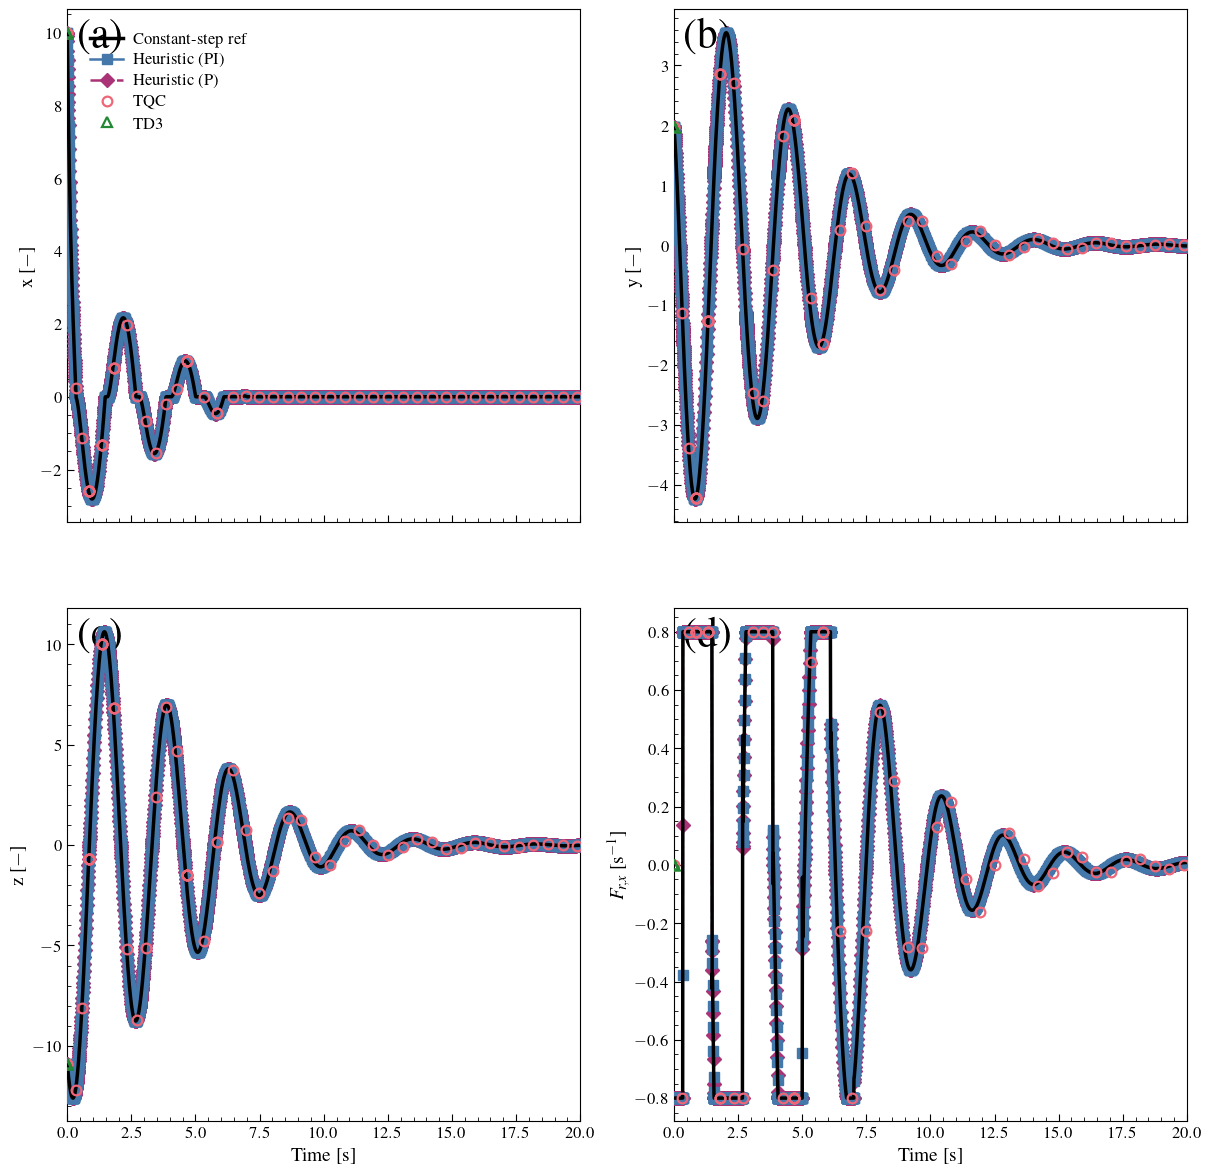

4-panel comparison saved to Images/control_state3_force_comparison.pdf and Images/control_state3_force_comparison.png


In [40]:
# 2×2 figure: x(t), y(t), z(t), F_{r,x}(t) — square panels, inset legend only in (a)
# Set uniform, publication-friendly font sizes and line widths; match figure width to FOSM (12 in)
plt.rcParams.update({
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "xtick.minor.width": 0.6,
    "ytick.minor.width": 0.6,
    # Bump sizes so they don't appear smaller than FOSM on a 2x2 layout
    "legend.fontsize": 12,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

fig, axes = plt.subplots(
    2, 2,
    figsize=(12, 12),            # width matches FOSM (12 in); keep square canvas for 2x2 layout
    constrained_layout=True,
    sharex=True
)
(ax_x, ax_y), (ax_z, ax_f) = axes

def _style(ax):
    ax.minorticks_on()
    ax.tick_params(axis="both", which="both", direction="in")
    ax.tick_params(axis="both", which="major", length=5)
    ax.tick_params(axis="both", which="minor", length=3)
    ax.grid(False)
    ax.margins(x=0.02, y=0.05)
    ax.set_box_aspect(1)           # <- make each axes square

for _ax in (ax_x, ax_y, ax_z, ax_f):
    _style(_ax)

# ---- (a) x(t) — the ONLY panel with legend (inset)
line_const,   = ax_x.plot(const_t, const_Y[:, 0], color=COLORS["const"], linewidth=2.5, label="Constant-step ref", zorder=5)
line_pi,      = ax_x.plot(t_custom_pi, Y_custom_pi[:, 0], linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, label="Heuristic (PI)", zorder=4)
line_p,       = ax_x.plot(t_custom_p,  Y_custom_p[:, 0],  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, label="Heuristic (P)",  zorder=3)
line_tqc,     = ax_x.plot(tts_saved_tqc, Ys_saved_tqc[:, 0], linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, label="TQC", zorder=6)
line_td3,     = ax_x.plot(tts_saved_td3, Ys_saved_td3[:, 0], linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, label="TD3", zorder=6)
ax_x.set_ylabel("x [−]")
ax_x.text(0.02, 0.98, "(a)", transform=ax_x.transAxes, va="top", ha="left")

# Build a deduped, compact legend and INSET it inside (a) — single column, no box
handles = [line_const, line_pi, line_p, line_tqc, line_td3]
labels  = [h.get_label() for h in handles]
by_label = dict(zip(labels, handles))
leg = ax_x.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper left",
    bbox_to_anchor=(0.02, 0.98),   # inset inside axes
    frameon=False,                 # remove legend box
    ncol=1,                        # single column (stacked)
    handlelength=2.0,
    handletextpad=0.6,
    borderpad=0.25,
    labelspacing=0.35,
)

# ---- (b) y(t) — no legend
ax_y.plot(const_t, const_Y[:, 1], color=COLORS["const"], linewidth=2.5, zorder=5)
ax_y.plot(t_custom_pi, Y_custom_pi[:, 1], linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, zorder=4)
ax_y.plot(t_custom_p,  Y_custom_p[:, 1],  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, zorder=3)
ax_y.plot(tts_saved_tqc, Ys_saved_tqc[:, 1], linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, zorder=6)
ax_y.plot(tts_saved_td3, Ys_saved_td3[:, 1], linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, zorder=6)
ax_y.set_ylabel("y [−]")
ax_y.text(0.02, 0.98, "(b)", transform=ax_y.transAxes, va="top", ha="left")

# ---- (c) z(t) — no legend
ax_z.plot(const_t, const_Y[:, 2], color=COLORS["const"], linewidth=2.5, zorder=5)
ax_z.plot(t_custom_pi, Y_custom_pi[:, 2], linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, zorder=4)
ax_z.plot(t_custom_p,  Y_custom_p[:, 2],  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, zorder=3)
ax_z.plot(tts_saved_tqc, Ys_saved_tqc[:, 2], linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, zorder=6)
ax_z.plot(tts_saved_td3, Ys_saved_td3[:, 2], linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, zorder=6)
ax_z.set_xlabel("Time [s]")
ax_z.set_ylabel("z [−]")
ax_z.text(0.02, 0.98, "(c)", transform=ax_z.transAxes, va="top", ha="left")

# ---- (d) F_{r,x}(t) — x-only force; no legend
t_force_const = _align_time_with_step_series(const_t, const_fkx)
t_force_pi    = _align_time_with_step_series(t_custom_pi, fkx_custom_pi)
t_force_p     = _align_time_with_step_series(t_custom_p,  fkx_custom_p)
t_force_tqc   = _align_time_with_step_series(tts_saved_tqc, fks_saved_tqc)
t_force_td3   = _align_time_with_step_series(tts_saved_td3, fks_saved_td3)

ax_f.plot(t_force_const, const_fkx, color=COLORS["const"], linewidth=2.5, zorder=5)
ax_f.plot(t_force_pi,    fkx_custom_pi, linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, zorder=4)
ax_f.plot(t_force_p,     fkx_custom_p,  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, zorder=3)
ax_f.plot(t_force_tqc,   fks_saved_tqc, linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, zorder=6)
ax_f.plot(t_force_td3,   fks_saved_td3, linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, zorder=6)
ax_f.set_xlabel("Time [s]")
ax_f.set_ylabel(r"$F_{r,x}$ [s$^{-1}$]")
ax_f.text(0.02, 0.98, "(d)", transform=ax_f.transAxes, va="top", ha="left")

# consistent x-limits across panels (helps alignment perception in print)
ax_x.set_xlim(t_span[0], t_span[1])

fig.savefig(STATE3F_PDF, bbox_inches="tight", facecolor="white")
fig.savefig(STATE3F_PNG, dpi=600, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print(f"4-panel comparison saved to {STATE3F_PDF} and {STATE3F_PNG}")


In [ ]:
# # 2×2 figure: x(t), y(t), z(t), F_{r,x}(t) — square panels, inset legend only in (a)
# plt.rcParams.update({
#     "axes.linewidth": 0.8,
#     "xtick.major.width": 0.8,
#     "ytick.major.width": 0.8,
#     "xtick.minor.width": 0.6,
#     "ytick.minor.width": 0.6,
#     "legend.fontsize": 9,
#     "axes.labelsize": 11,
#     "xtick.labelsize": 10,
#     "ytick.labelsize": 10,
# })

# fig, axes = plt.subplots(
#     2, 2,
#     figsize=(12, 12),            # square canvas so each panel can be square
#     constrained_layout=True,
#     sharex=True
# )
# (ax_x, ax_y), (ax_z, ax_f) = axes

# def _style(ax):
#     ax.minorticks_on()
#     ax.tick_params(axis="both", which="both", direction="in")
#     ax.tick_params(axis="both", which="major", length=5)
#     ax.tick_params(axis="both", which="minor", length=3)
#     ax.grid(False)
#     ax.margins(x=0.02, y=0.05)
#     ax.set_box_aspect(1)           # <- make each axes square

# for _ax in (ax_x, ax_y, ax_z, ax_f):
#     _style(_ax)

# # ---- (a) x(t) — the ONLY panel with legend (inset)
# line_const,   = ax_x.plot(const_t, const_Y[:, 0], color=COLORS["const"], linewidth=2.5, label="Constant-step ref", zorder=5)
# line_pi,      = ax_x.plot(t_custom_pi, Y_custom_pi[:, 0], linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, label="Heuristic (PI)", zorder=4)
# line_p,       = ax_x.plot(t_custom_p,  Y_custom_p[:, 0],  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, label="Heuristic (P)",  zorder=3)
# line_tqc,     = ax_x.plot(tts_saved_tqc, Ys_saved_tqc[:, 0], linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, label="TQC", zorder=6)
# line_td3,     = ax_x.plot(tts_saved_td3, Ys_saved_td3[:, 0], linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, label="TD3", zorder=6)
# ax_x.set_ylabel("x [−]")
# ax_x.text(0.02, 0.98, "(a)", transform=ax_x.transAxes, va="top", ha="left")

# # Build a deduped, compact legend and INSET it inside (a)
# handles = [line_const, line_pi, line_p, line_tqc, line_td3]
# labels  = [h.get_label() for h in handles]
# by_label = dict(zip(labels, handles))
# leg = ax_x.legend(
#     by_label.values(),
#     by_label.keys(),
#     loc="upper left",
#     bbox_to_anchor=(0.02, 0.98),   # inset inside axes
#     frameon=True,
#     ncol=2,
#     handlelength=2.0,
#     handletextpad=0.6,
#     borderpad=0.25,
#     labelspacing=0.35,
#     columnspacing=0.9
# )
# # a subtle, clean legend box
# leg.get_frame().set_alpha(0.9)
# leg.get_frame().set_edgecolor((0, 0, 0, 0.15))
# leg.get_frame().set_linewidth(0.6)

# # ---- (b) y(t) — no legend
# ax_y.plot(const_t, const_Y[:, 1], color=COLORS["const"], linewidth=2.5, zorder=5)
# ax_y.plot(t_custom_pi, Y_custom_pi[:, 1], linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, zorder=4)
# ax_y.plot(t_custom_p,  Y_custom_p[:, 1],  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, zorder=3)
# ax_y.plot(tts_saved_tqc, Ys_saved_tqc[:, 1], linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, zorder=6)
# ax_y.plot(tts_saved_td3, Ys_saved_td3[:, 1], linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, zorder=6)
# ax_y.set_ylabel("y [−]")
# ax_y.text(0.02, 0.98, "(b)", transform=ax_y.transAxes, va="top", ha="left")

# # ---- (c) z(t) — no legend
# ax_z.plot(const_t, const_Y[:, 2], color=COLORS["const"], linewidth=2.5, zorder=5)
# ax_z.plot(t_custom_pi, Y_custom_pi[:, 2], linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, zorder=4)
# ax_z.plot(t_custom_p,  Y_custom_p[:, 2],  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, zorder=3)
# ax_z.plot(tts_saved_tqc, Ys_saved_tqc[:, 2], linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, zorder=6)
# ax_z.plot(tts_saved_td3, Ys_saved_td3[:, 2], linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, zorder=6)
# ax_z.set_xlabel("Time [s]")
# ax_z.set_ylabel("z [−]")
# ax_z.text(0.02, 0.98, "(c)", transform=ax_z.transAxes, va="top", ha="left")

# # ---- (d) F_{r,x}(t) — x-only force; no legend
# t_force_const = _align_time_with_step_series(const_t, const_fkx)
# t_force_pi    = _align_time_with_step_series(t_custom_pi, fkx_custom_pi)
# t_force_p     = _align_time_with_step_series(t_custom_p,  fkx_custom_p)
# t_force_tqc   = _align_time_with_step_series(tts_saved_tqc, fks_saved_tqc)
# t_force_td3   = _align_time_with_step_series(tts_saved_td3, fks_saved_td3)

# ax_f.plot(t_force_const, const_fkx, color=COLORS["const"], linewidth=2.5, zorder=5)
# ax_f.plot(t_force_pi,    fkx_custom_pi, linestyle="-",  marker=MARKERS["pi"], markersize=7, color=COLORS["pi"], linewidth=1.8, zorder=4)
# ax_f.plot(t_force_p,     fkx_custom_p,  linestyle="-.", marker=MARKERS["p"],  markersize=7, color=COLORS["p"],  linewidth=1.8, zorder=3)
# ax_f.plot(t_force_tqc,   fks_saved_tqc, linestyle="None", marker=MARKERS["tqc"], markersize=7, markerfacecolor="none", markeredgecolor=COLORS["tqc"], markeredgewidth=1.6, zorder=6)
# ax_f.plot(t_force_td3,   fks_saved_td3, linestyle="None", marker=MARKERS["td3"],  markersize=7, markerfacecolor="none", markeredgecolor=COLORS["td3"],  markeredgewidth=1.6, zorder=6)
# ax_f.set_xlabel("Time [s]")
# ax_f.set_ylabel(r"$F_{r,x}$ [s$^{-1}$]")
# ax_f.text(0.02, 0.98, "(d)", transform=ax_f.transAxes, va="top", ha="left")

# # consistent x-limits across panels (helps alignment perception in print)
# ax_x.set_xlim(t_span[0], t_span[1])

# fig.savefig(STATE3F_PDF, bbox_inches="tight", facecolor="white")
# fig.savefig(STATE3F_PNG, dpi=600, bbox_inches="tight", facecolor="white")
# plt.show()
# plt.close(fig)

# print(f"4-panel comparison saved to {STATE3F_PDF} and {STATE3F_PNG}")
